In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import numpy as np
import time
import xarray as xr

from tensorflow.keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from tensorflow.keras.utils.generic_utils import get_custom_objects
from tensorflow.keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [14]:
Datas = glob(os.getcwd() + '/Data/*.csv')
Datas

['/home/bouissob/Script/Data/data_Ocean1_COM_NEMO-CNRS.nc.csv']

In [15]:
Data = pd.read_csv(Datas[0])
Clean_Data = Data.loc[(~Data['meltRate'].isna() & ~Data['thermalDriving'].isna() & 
      ~Data['halineDriving'].isna() & ~Data['iceDraft'].isna())]
Clean_Data.reset_index(inplace=True)

In [16]:
Var_names_X = ['thermalDriving', 'x', 'y', 'iceDraft', 'halineDriving']
X = Clean_Data[Var_names_X]
Y = Clean_Data['meltRate']

In [17]:
X_train = X.sample(frac = 0.8)
X_valid = X.drop(X_train.index)

Y_train = Y.loc[X_train.index]
Y_valid = Y.drop(X_train.index)

In [18]:
mean, std = X_train.mean(), X_train.std() 
meanY, stdY = Y_train.mean(), Y_train.std() 
maxY = max(Y_train)
X_train_N, X_valid_N = np.array((X_train - mean)/std), np.array((X_valid - mean)/std)
#Y_train_N, Y_valid_N = np.array((Y_train-meanY)/stdY), np.array((Y_valid-meanY)/stdY)
Y_train_N, Y_valid_N = np.array(Y_train / maxY), np.array(Y_valid/maxY)

In [19]:
def Model_init(shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape))
    model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dense(32, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1, activation = 'relu'))
    model.compile(optimizer='adam',
                 loss = 'mse',
                metrics = ['mae', 'mse'])
    return model
def Model_init2(shape):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape))
    model.add(tf.keras.layers.Dense(32, activation = 'swish'))
    model.add(tf.keras.layers.Dense(64, activation = 'swish'))
    model.add(tf.keras.layers.Dense(64, activation = 'swish'))
    model.add(tf.keras.layers.Dense(32, activation = 'swish'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam',
                 loss = 'mse',
                metrics = ['mae', 'mse'])
    return model

In [20]:
Nbr_Epoch = 25
model = Model_init2( (5, ))
Model = model.fit(X_train_N, Y_train_N,
                   epochs = Nbr_Epoch,
                   batch_size = 10,
                   validation_data = (X_valid_N, Y_valid_N))
Model_path = os.getcwd() + '/Models/'
Temp = Datas[0].split('/')
Name = Temp[len(Temp) - 1].split('.')[0] + '%' +str(time.time())
filepath = Model_path + Name
#tf.keras.models.save_model(
#    Model.model, filepath, overwrite=True, include_optimizer=True, save_format=None,
#    signatures=None, options=None, save_traces=True
#)
model.save(filepath + '.h5')
model.evaluate(X_train, Y_train, verbose = 0)

Epoch 1/25
55834/55834 [==============================] - 84s 1ms/step - loss: 0.0021 - mae: 0.0219 - mse: 0.0021 - val_loss: 4.4552e-04 - val_mae: 0.0105 - val_mse: 4.4552e-04
Epoch 2/25
55834/55834 [==============================] - 83s 1ms/step - loss: 5.8712e-04 - mae: 0.0117 - mse: 5.8712e-04 - val_loss: 7.8496e-04 - val_mae: 0.0134 - val_mse: 7.8496e-04
Epoch 3/25
55834/55834 [==============================] - 83s 1ms/step - loss: 5.0087e-04 - mae: 0.0106 - mse: 5.0087e-04 - val_loss: 5.4257e-04 - val_mae: 0.0119 - val_mse: 5.4257e-04
Epoch 4/25
55834/55834 [==============================] - 83s 1ms/step - loss: 3.9298e-04 - mae: 0.0096 - mse: 3.9298e-04 - val_loss: 2.9961e-04 - val_mae: 0.0083 - val_mse: 2.9961e-04
Epoch 5/25
55834/55834 [==============================] - 86s 2ms/step - loss: 3.5948e-04 - mae: 0.0091 - mse: 3.5948e-04 - val_loss: 2.0239e-04 - val_mae: 0.0074 - val_mse: 2.0239e-04
Epoch 6/25
55834/55834 [==============================] - 84s 2ms/step - loss: 3.10

[14474935.0, 2491.6435546875, 14474935.0]

In [21]:
model.save(filepath + '.h5')

/home/bouissob/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


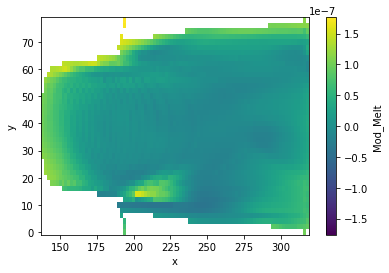

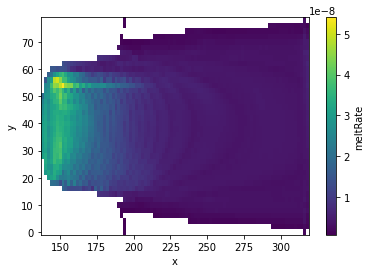

In [25]:
Data = Clean_Data.loc[Clean_Data.date == 1]
X = Data[Var_names_X]
X = np.array((X - mean)/std)
X = np.array(X).reshape(-1, 5, )
Y_mod = Model.model(X)
Data['Mod_Melt'] = Y_mod.numpy().reshape(len(Y_mod, )) * maxY
#Data['Mod_Melt'] = (Y_mod.numpy().reshape(len(Y_mod, )) * stdY) + meanY
Dataset = Data.set_index(['y', 'x'])
Dataset = Dataset.to_xarray()
Dataset.Mod_Melt.plot(cmap = plt.get_cmap('viridis'))
plt.figure()
Dataset.meltRate.plot(cmap = plt.get_cmap('viridis'))

In [101]:
Norm_path = '/home/bouissob/Script/Models/Norm_values_for_models/'
N_path = Norm_path + Name + '/'
if not os.path.isdir(N_path):
    os.makedirs(N_path)
mean.to_pickle(N_path + 'MeanX.pkl')
std.to_pickle(N_path + 'StdX.pkl')
np.savetxt(N_path + 'MaxY.csv', np.array(maxY).reshape(1, ))
tmx = int(Clean_Data.loc[len(Clean_Data) - 1].date)
#STD = pd.read_pickle(pwd + '/std.pkl')

In [104]:
STD = pd.read_pickle(N_path + 'StdX.pkl')

In [114]:
Data[Var_names_X] / STD

,thermalDriving,x,y,iceDraft,halineDriving
2908,0.021486,3.853261,0.000000,0.697364,0.031098
2909,0.034605,6.276446,0.000000,0.768610,0.050021
2910,0.022203,3.853261,0.103437,0.687563,0.032132
2911,0.032137,5.839479,0.103437,0.757089,0.046467
2912,0.028122,5.879203,0.103437,0.760231,0.040684
...,...,...,...,...,...
5811,0.028717,6.236722,3.930616,0.842069,0.041552
5812,0.036860,6.276446,3.930616,0.900406,0.053301
5813,0.022240,6.316171,3.930616,0.842069,0.032217
5814,0.025435,3.853261,4.034053,0.695271,0.036803


In [115]:
Data[Var_names_X]

,thermalDriving,x,y,iceDraft,halineDriving
2908,0.006723,194,0,82.815510,0.094629
2909,0.010828,316,0,91.276440,0.152211
2910,0.006948,194,2,81.651650,0.097775
2911,0.010056,294,2,89.908270,0.141399
2912,0.008800,296,2,90.281364,0.123800
...,...,...,...,...,...
5811,0.008986,314,76,100.000000,0.126443
5812,0.011534,316,76,106.927826,0.162194
5813,0.006959,318,76,100.000000,0.098036
5814,0.007959,194,78,82.566990,0.111991
